Kiki Chandra & Zoher Ghadyali

Data Science Spring 2016

CYOA Project

# MODEL ITERATION 1

In this iteration of the model, building off of the results of our data exploration, we break our data up into subsets of single words, sentences, and phrases. We then apply a variety of different techniques to determine the sentiment of these different categories. We use a bag of words or tfidf approach primarily for sentences. For single words, we look for whether or not they are positive or negative from other sources. For phrases, we average the sentiments obtained from the single words. In our second model, we break up the data further into sentences, long phrases, medium phrases, short phrases, and single words and follow a similar process.

## Bag of Words Model

Below we set up our train and test data so we can implement a bag of words model while still separating our data into sentences, phrases, and single words. Our review to words function parses the sentences and the phrases and removes punctuation, stopwords, and makes all of the words lowercase. We create a placeholder in our test data for sentiment and we create our subset of sentences from the train and test data.

In [2]:
import re
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import nltk
from nltk.corpus import stopwords # Import the stop word list
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import cross_validation
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestClassifier


%matplotlib inline

def review_to_words( raw_review ):
    letters_only = re.sub("[^a-zA-Z]", " ", raw_review) 
    words = letters_only.lower().split()                             
    stops = set(stopwords.words("english"))                  
    meaningful_words = [w for w in words if not w in stops]   
    return( " ".join( meaningful_words ))   

train_df = pd.read_table('train.tsv')
test_df = pd.read_table('test.tsv')

test_df['Sentiment'] = -1 #a placeholder value, once we break up the test data into subsets, we can change this value
train_sentences = train_df.groupby('SentenceId').first().reset_index()
test_sentences = test_df.groupby('SentenceId').first().reset_index()
train_sentences["Phrase"] = train_sentences["Phrase"].apply(review_to_words)
test_sentences["Phrase"] = test_sentences["Phrase"].apply(review_to_words)

We use the tfidf vectorizer and a multinomial Naive Bayes model to fit the data. We have a very low accuracy from this model and one interesting thing to note is that this model predicts a majority of the sentences in the test dataset as 1s and 3s. There are not a lot of parameters to play around with in this model but this is very interesting behavior because we could get a baseline Kaggle score just by guessing 2 for every sentence, phrase, and single word, which we do later in this notebook.

Accuracy 0.392437801424


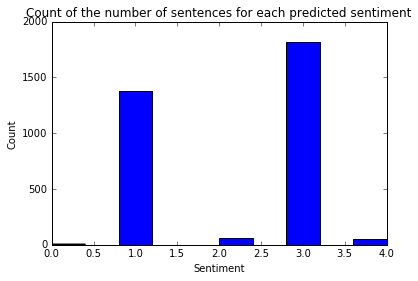

Sentiment:  0 Percentage:  0.00211480362538
Sentiment:  1 Percentage:  0.415709969789
Sentiment:  2 Percentage:  0.0190332326284
Sentiment:  3 Percentage:  0.548640483384
Sentiment:  4 Percentage:  0.014501510574


In [3]:
vectorizer = TfidfVectorizer()
vectorizer.fit(train_sentences.Phrase)

train_sentences_features = vectorizer.transform(train_sentences.Phrase)
test_sentences_features = vectorizer.transform(test_sentences.Phrase)

clf = MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)
scores = cross_validation.cross_val_score(clf, train_sentences_features, train_sentences["Sentiment"], cv=10)
print "Accuracy", scores.mean()

clf = clf.fit(train_sentences_features, train_sentences["Sentiment"])
result = clf.predict(test_sentences_features)
sentences = pd.DataFrame(data={"PhraseId":test_sentences["PhraseId"], "Sentiment":result})

plt.hist(sentences.Sentiment)
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.title('Count of the number of sentences for each predicted sentiment')
plt.show()
for i in range(0, 5):
    print "Sentiment: ", i, "Percentage: ", len(sentences[sentences.Sentiment == i]) / float(len(sentences))

We find the single words in the data in the same way that we did during our data exploration. We then downloaded two .txt files from UNC that contain positive and negative words. In predicting the sentiment for the single words, we look to see if the given word is in either of these lists and assign it a 1 or a 3 if it is in the negative or positive list respectively. We do not assign 0s or 4s assuming that no single word has an exteme positive or negative sentiment without context. If the word is not in either list, we assign it a 2.

We plot a histogram of the sentiment for the single words and we find that 83% of the single words have a sentiment of 2 which makes sense given that the positive and negative word text files only contain 3000 words each. Most words are probably not in either list and so given a sentiment of 2. We do find that 16% of single words are contained in one of these lists and, unsurprisingly, there are 0 words with a sentiment of 0 or 4.

Finally, we merge the sentiments that our tfidf model predicted for the sentences with the sentiments predicted for the single words. This lets us now find all remaning phrases that we haven't yet predicted the sentiment for and, once we do predict their sentiment, we can merge that dataframe into this merged one to have predictions for all of the test data.

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


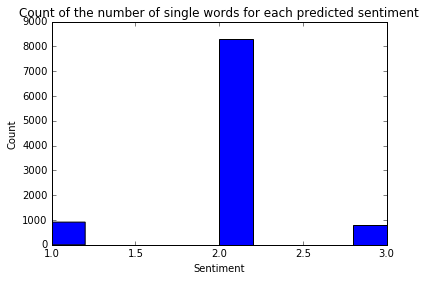

Sentiment:  0 Percentage:  0.0
Sentiment:  1 Percentage:  0.0913720790893
Sentiment:  2 Percentage:  0.830037946874
Sentiment:  3 Percentage:  0.0785899740363
Sentiment:  4 Percentage:  0.0


In [5]:
negWords = open("negative.txt").read().split("\n")
posWords = open("positive.txt").read().split("\n")

test_df["containsSpaces"] = test_df["Phrase"].apply(lambda x: ' ' in x)
test_sw = test_df[test_df.containsSpaces == False]

def get_sentiment_single_word(word):
    """Takes in as input a single word, checks if the word is in two text files we downloaded of negative and positive
    words, and returns the corresponding value. We use 1 and 3 instead of 0 and 4 because we assume no single word can
    have an extremely negative or positive sentiment."""
    if word in negWords:
        return 1
    elif word in posWords:
        return 3
    else:
        return 2
    
test_sw['Sentiment'] = test_sw['Phrase'].apply(get_sentiment_single_word)

sw = test_sw[['PhraseId', 'Sentiment']]

plt.hist(sw.Sentiment)
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.title('Count of the number of single words for each predicted sentiment')
plt.show()
for i in range(0, 5):
    print "Sentiment: ", i, "Percentage: ", len(sw[sw.Sentiment == i]) / float(len(sw))

merged1 = pd.merge(sentences, sw, how='outer') #outer gets all rows from both dataframes which is what we want to
                                               #produce all the rows we need in the test data

We now get all the remaning phrases that we have not yet predicted the sentiment for in the test data and we clean them. We create a dictionary using the dataframe we created of the single words to essentially use as a lookup table. We loop through the words in each phrase, get their sentiment from the dictionary or, if they aren't in the dictionary add a 2, and then average the list. If the list is empty, we return a 2.

We then merge the remaining phrases with our previous merged data frame that contained our sentences and single words. We print out the length of the data frame after this merge to ensure that we have calculated the sentiment for all of the rows in the test data.

In [25]:
remainingPhrases = test_df[~test_df['PhraseId'].isin(merged1['PhraseId'])].reset_index()
remainingPhrases["Phrase"] = remainingPhrases["Phrase"].apply(review_to_words)

sw_dict = test_sw.set_index('Phrase')['Sentiment'].to_dict()

def get_sentiment_phrase(phrase):
    phrase_sentiment = []
    for word in phrase.split():
        if word in sw_dict:
            phrase_sentiment.append(sw_dict[word])
        else:
            phrase_sentiment.append(2)
    if len(phrase_sentiment):
        return sum(phrase_sentiment)/len(phrase_sentiment)
    else:
        return 2

remainingPhrases['Sentiment'] = remainingPhrases['Phrase'].apply(get_sentiment_phrase)
phrases = remainingPhrases[['PhraseId', 'Sentiment']]
merged2 = pd.merge(merged1, phrases, how='outer')
print len(merged2)

66292


Now that we have verified that we have predicted the sentiment for all of the phrases, sentences, and single words in the test data, we sort by PhraseId, ensure that the PhraseId and Sentiments are stored as integers and not as strings, and output the result as a csv.

In [34]:
final = merged2.sort_values(by='PhraseId')
final['PhraseId'] = final['PhraseId'].apply(lambda x: int(x))
final['Sentiment'] = final['Sentiment'].apply(lambda x: int(x))
final.to_csv( "ZG_rotten_tomatoes_model1.csv", index=False, quoting=3 )

This csv file got a Kaggle score of 0.52572. This method is somewhat difficult to interpret because we cannot gauge the accuracy of our models separately. We do not know if our bag of words model is very accurate or if our functions for single words and phrases is good. To see how this model compares to a baseline, we decided to just guess 2 for every row in the test data.

In [36]:
baseline = merged2.sort_values(by='PhraseId')
baseline['PhraseId'] = final['PhraseId'].apply(lambda x: int(x))
baseline['Sentiment'] = final['Sentiment'].apply(lambda x: 2)
baseline.to_csv( "ZG_rotten_tomatoes_baseline.csv", index=False, quoting=3 )

By guessing 2 for every row in the test data, we get a Kaggle score of 0.51789. So we see that our model for sentences, phrases, and single words is only providing a 0.00783% improvement than just guessing 2. We try a slightly different approach below.

We then tried using the bag of words on separate groups of sentences, long phrases, phrases, shorter phrases, and single words. To do this, we created a length of words in phrase column and binned the rows into the group that corresponded with the phrase length. 

In [3]:
train = pd.read_table('train.tsv')
train["Length"] = train['Phrase'].apply(lambda x: len(x.split()))
ordered = train.sort(['SentenceId', 'Length'], ascending=[1, 0])
train_sentences = train.groupby('SentenceId').first().reset_index()


max_length = max(ordered['Length'])
bins = [0, 1, max_length/15, max_length/4, max_length/2, max_length]
group_names = ['SingleWord', 'SmallPhrase', 'Phrase', 'LongPhrase', 'Sentences']
categories = pd.cut(ordered['Length'], bins, labels=group_names)
ordered['categories'] = pd.cut(ordered['Length'], bins, labels=group_names)


sentences = ordered[ordered['categories'] == 'Sentences'].reset_index()
longphrase = ordered[ordered['categories'] == 'LongPhrase'].reset_index()
phrase = ordered[ordered['categories'] == 'Phrase'].reset_index()
smallphrase = ordered[ordered['categories'] == 'SmallPhrase'].reset_index()
singleword = ordered[ordered['categories'] == 'SingleWord'].reset_index()
print bins[::-1]
print len(sentences), len(longphrase), len(phrase), len(smallphrase), len(singleword)
ordered

[52, 26, 13, 3, 1, 0]
4193 20141 68215 46979 16531


/home/kiki/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:3: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  app.launch_new_instance()


,PhraseId,SentenceId,Phrase,Sentiment,Length,categories
0,1,1,A series of escapades demonstrating the adage ...,1,37,Sentences
27,28,1,"is also good for the gander , some of which oc...",2,23,LongPhrase
28,29,1,"is also good for the gander , some of which oc...",2,22,LongPhrase
31,32,1,"good for the gander , some of which occasional...",2,20,LongPhrase
32,33,1,"for the gander , some of which occasionally am...",2,19,LongPhrase
33,34,1,"the gander , some of which occasionally amuses...",1,18,LongPhrase
38,39,1,some of which occasionally amuses but none of ...,2,15,LongPhrase
1,2,1,A series of escapades demonstrating the adage ...,2,14,LongPhrase
5,6,1,of escapades demonstrating the adage that what...,2,12,Phrase
43,44,1,occasionally amuses but none of which amounts ...,2,12,Phrase


We made a basic cleaning function to parse the phrase and remove words that aren't considered to be meaningful words. These words are typically called stopwords, containing words such as 'is' and 'the'. We then iterate through each data frame and clean the phrases

In [ ]:
def review_to_words( raw_review ):
    letters_only = re.sub("[^a-zA-Z]", " ", raw_review) 
    words = letters_only.lower().split()                             
    stops = set(stopwords.words("english"))                  
    meaningful_words = [w for w in words if not w in stops]   
    return( " ".join( meaningful_words )) 

In [ ]:
num_reviews_sent = sentences["Phrase"].size
clean_sent_reviews = []

for i in xrange(0, num_reviews_sent):
    clean_sent_reviews.append( review_to_words(sentences["Phrase"][i]))
    
num_reviews_long = longphrase["Phrase"].size
clean_long_reviews = []

for i in xrange(0, num_reviews_long):
    clean_long_reviews.append( review_to_words(longphrase["Phrase"][i]))
    
num_reviews_p = phrase["Phrase"].size
clean_p_reviews = []

for i in xrange(0, num_reviews_p):
    clean_p_reviews.append( review_to_words(phrase["Phrase"][i]))
    
num_reviews_small = smallphrase["Phrase"].size
clean_small_reviews = []

for i in xrange(0, num_reviews_small):
    clean_small_reviews.append( review_to_words(smallphrase["Phrase"][i]))

num_reviews_single = singleword["Phrase"].size
clean_single_reviews = []

for i in xrange(0, num_reviews_single):
    clean_single_reviews.append( review_to_words(singleword["Phrase"][i]))

We used count vectorizer to create a count of the word tokens as vectors, representing the amount of times they appear in phrase. We played around with the max_features values to see how that would increase the accuracy - it really only made a difference of about ~0.004 at most, which is good but not very significant. Then, we applied our models to each data frame. 

In [ ]:
vectorizer = CountVectorizer(analyzer = "word",   \
                             tokenizer = None,    \
                             preprocessor = None, \
                             stop_words = None,   \
                             max_features = 4000) 

# fit_transform() does two functions: First, it fits the model
# and learns the vocabulary; second, it transforms our training data
# into feature vectors. The input to fit_transform should be a list of 
# strings.
sent_data_features = vectorizer.fit_transform(clean_sent_reviews)
sent_data_features = sent_data_features.toarray()

long_data_features = vectorizer.fit_transform(clean_long_reviews)
long_data_features = long_data_features.toarray()

p_data_features = vectorizer.fit_transform(clean_p_reviews)
p_data_features = p_data_features.toarray()

small_data_features = vectorizer.fit_transform(clean_small_reviews)
small_data_features = small_data_features.toarray()

single_data_features = vectorizer.fit_transform(clean_single_reviews)
single_data_features = single_data_features.toarray()

In [ ]:
print sent_data_features.shape, long_data_features.shape, p_data_features.shape, small_data_features.shape, single_data_features.shape

Shapes: (4193, 4000) (20141, 4000) (68215, 4000) (46979, 4000) (16531, 4000)

To ensure that the vectorizer ran as intended, we then printed out some values in the vocabulary created from running it.

In [ ]:
# Sum up the counts of each vocabulary word
dist = np.sum(sent_data_features, axis=0)

# For each, print the vocabulary word and the number of times it 
# appears in the training set
for tag, count in zip(vocab, dist):
    print count, tag

26 aaa <br>
37 able <br>
5 absorbed <br>
8 accident <br>
7 act <br>
10 acted <br>
5 acting <br>
10 action <br>
10 actor <br>
5 actress <br>
5 adolescent <br>
8 adrenaline <br>
5 adult <br>
6 adults <br>
13 adventure <br>
6 advised <br>
9 affectation <br>
5 affirming <br>
8 african <br>
5 age <br>
5 aged <br>
12 agency <br>
17 agenda <br>
...

We decided to use a random forest classifier to see its accuracy compared to the multinomial model that we previously ran. Here we train the model with the training set:

In [ ]:
# Initialize a Random Forest classifier with 100 trees
forest_sent = RandomForestClassifier(n_estimators = 50)
forest_long = RandomForestClassifier(n_estimators = 40) 
forest_p = RandomForestClassifier(n_estimators = 30)
forest_small = RandomForestClassifier(n_estimators = 20)
forest_single = RandomForestClassifier(n_estimators = 20) 

# Fit the forest to the training set, using the bag of words as 
# features and the sentiment labels as the response variable
# This may take a few minutes to run
forest_sent = forest_sent.fit(sent_data_features, sentences["Sentiment"])
forest_long = forest_long.fit(long_data_features, longphrase["Sentiment"])
forest_p = forest_p.fit(p_data_features, phrase["Sentiment"])
forest_small = forest_small.fit(small_data_features, smallphrase["Sentiment"])
forest_single = forest_single.fit(single_data_features, singleword["Sentiment"])

Once the model has been trained, we ran the above code on the test data, creating separate data frames and cleaning the data. Then, we apply the random forest models to each group. 

In [ ]:
ordered = test.sort(['SentenceId', 'Length'], ascending=[1, 0])

max_length = max(ordered['Length'])
bins = [0, 1, max_length/15, max_length/4, max_length/2, max_length]
group_names = ['SingleWord', 'SmallPhrase', 'Phrase', 'LongPhrase', 'Sentences']
categories = pd.cut(ordered['Length'], bins, labels=group_names)
ordered['categories'] = pd.cut(ordered['Length'], bins, labels=group_names)


sentences = ordered[ordered['categories'] == 'Sentences'].reset_index()
longphrase = ordered[ordered['categories'] == 'LongPhrase'].reset_index()
phrase = ordered[ordered['categories'] == 'Phrase'].reset_index()
smallphrase = ordered[ordered['categories'] == 'SmallPhrase'].reset_index()
singleword = ordered[ordered['categories'] == 'SingleWord'].reset_index()


num_reviews_sent = sentences["Phrase"].size
clean_sent_reviews = []

print "Cleaning and parsing the test set movie reviews...\n"
for i in xrange(0, num_reviews_sent):
    clean_sent_reviews.append( review_to_words(sentences["Phrase"][i]))
    if( (i+1) % 10000 == 0 ):
        print "Review %d of %d\n" % (i+1, len(ordered))
    
num_reviews_long = longphrase["Phrase"].size
clean_long_reviews = []

for i in xrange(0, num_reviews_long):
    clean_long_reviews.append( review_to_words(longphrase["Phrase"][i]))
    if( (i+1) % 10000 == 0 ):
        print "Review %d of %d\n" % (i+1, len(ordered))
        
num_reviews_p = phrase["Phrase"].size
clean_p_reviews = []

for i in xrange(0, num_reviews_p):
    clean_p_reviews.append( review_to_words(phrase["Phrase"][i]))
    if( (i+1) % 10000 == 0 ):
        print "Review %d of %d\n" % (i+1, len(ordered))
    
num_reviews_small = smallphrase["Phrase"].size
clean_small_reviews = []

for i in xrange(0, num_reviews_small):
    clean_small_reviews.append( review_to_words(smallphrase["Phrase"][i]))
    if( (i+1) % 10000 == 0 ):
        print "Review %d of %d\n" % (i+1, len(ordered))

num_reviews_single = singleword["Phrase"].size
clean_single_reviews = []

for i in xrange(0, num_reviews_single):
    clean_single_reviews.append( review_to_words(singleword["Phrase"][i]))
    if( (i+1) % 10000 == 0 ):
        print "Review %d of %d\n" % (i+1, len(ordered))

print "Applying tree to sentences...\n"        
sent_data_features = vectorizer.fit_transform(clean_sent_reviews)
sent_data_features = sent_data_features.toarray()
result_sent = forest_sent.predict(sent_data_features)

print "Applying tree to long phrases...\n" 
long_data_features = vectorizer.fit_transform(clean_long_reviews)
long_data_features = long_data_features.toarray()
result_long = forest_long.predict(long_data_features)

print "Applying tree to mid phrases...\n" 
p_data_features = vectorizer.fit_transform(clean_p_reviews)
p_data_features = p_data_features.toarray()
result_p = forest_p.predict(p_data_features)

print "Applying tree to small phrases...\n" 
small_data_features = vectorizer.fit_transform(clean_small_reviews)
small_data_features = small_data_features.toarray()
result_small = forest_small.predict(small_data_features)

print "Applying tree to single words...\n" 
single_data_features = vectorizer.fit_transform(clean_single_reviews)
single_data_features = single_data_features.toarray()
result_single = forest_single.predict(single_data_features)

#print result_sent, result_long, result_small, result_single

# Copy the results to a pandas dataframe with an "id" column and
# a "sentiment" column
#output = pd.DataFrame(data={"PhraseId":test_sentences["PhraseId"], "Sentiment":result})

# Use pandas to write the comma-separated output file
#output.to_csv( "rotten_tomatoes_model.csv", index=False, quoting=3 )
print "done predicting"

Cleaning and parsing the test set movie reviews... <br>

Review 10000 of 66292<br>

Review 20000 of 66292<br>

Review 10000 of 66292<br>

Review 10000 of 66292<br>

Applying tree to sentences...<br>

Applying tree to long phrases...<br>

Applying tree to mid phrases...<br>

Applying tree to small phrases...<br>

Applying tree to single words...<br>

done predicting<br>

Once we finished applying the models, we set the test data 'Sentiment' column to the values generated through the model. We also printed out the length to verify that we didn't lose any rows.

In [ ]:
sentences['Sentiment'] = result_sent.tolist()
longphrase['Sentiment'] = result_long.tolist()
phrase['Sentiment'] = result_p.tolist()
smallphrase['Sentiment'] = result_small.tolist()
singleword['Sentiment'] = result_single.tolist()
print len(sentences)+len(longphrase)+len(phrase)+len(smallphrase)+len(singleword)

66291

In [ ]:
output = pd.DataFrame(data={"PhraseId":df3["PhraseId"], "Sentiment":df3['Sentiment']})

# Use pandas to write the comma-separated output file
output.to_csv( "rotten_tomatoes_model.csv", index=False, quoting=3 )

Kaggle score: 0.5181 <br>
Running this model gave us a slight improvement on the multinomial model. However, much of our structure and process was determined through looking at tutorials so we could get a chance to learn in a structured way. Now that we have a better sense of what can impact the overall accuracy, and what different directions we can go in, we will try new models that can be significant improvements on these. 

## Conclusions

We tried a lot of very different things in this first iteration of the model but because we do not have access to the actual sentiments of the test data, we found it really hard to find the problems with this iteration of the model since we couldn't tell how accurate our sentences model, single words model, and phrases model were doing. Even if we used a train-test split on the train data, in some of the subsets, especially the sentences and single words, there are so few to train and test on that we didn't feel like we could accurately predict how the model would do on the test data. 

We tried to make the model less opaque in our second iteration, which is contained in Model_Iteration_2_FINAL.ipynb.